In [1]:
!pip -q install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [100]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import utils
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import pandas as pd
import numpy as np
import pickle
from pathlib import Path

In [4]:
predict_target = "price"

In [82]:
df = pd.read_csv("clean_OMEA_dataset.csv")

In [83]:
sellable_online_encoder = LabelEncoder()
other_colors_encoder = LabelEncoder()
feature_scaler = MinMaxScaler()
label_scaler = MinMaxScaler()

df['sellable_online'] = sellable_online_encoder.fit_transform(df['sellable_online'])
df['other_colors'] = other_colors_encoder.fit_transform(df['other_colors'])
df[['size', 'width', 'height', 'depth', 'discount_amount']] = feature_scaler.fit_transform(df[['size', 'width', 'height', 'depth', 'discount_amount']])
df[['price']] = label_scaler.fit_transform(df[['price']])

df = pd.get_dummies(df, columns=['category'])

df = df.drop(["name", "short_description", "old_price"], axis=1)

In [85]:
df_train, df_test = train_test_split(df, shuffle=True, test_size=0.3, random_state=42)

In [86]:
def create_model(my_learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(df_train.columns)-1,)),
        tf.keras.layers.Dense(20, activation='relu', name='Hidden1'),
        tf.keras.layers.Dense(10, activation='relu', name='Hidden2'),
        tf.keras.layers.Dense(1, name='Output')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [87]:
# Hyperparameters
learning_rate = 0.01
epochs = 20
batch_size = 2

# Create the model
model = create_model(learning_rate)

features = df_train.drop(predict_target, axis=1)
labels = df_train[[predict_target]]

# Fit the model
history = model.fit(features.values, labels.values, epochs=epochs, batch_size=batch_size)

Epoch 1/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 2s 757us/step - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 2/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 3/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 4/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 5/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 6/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 7/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 8/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 9/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 10/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 0.0077 - mean_squared_error: 0.0077

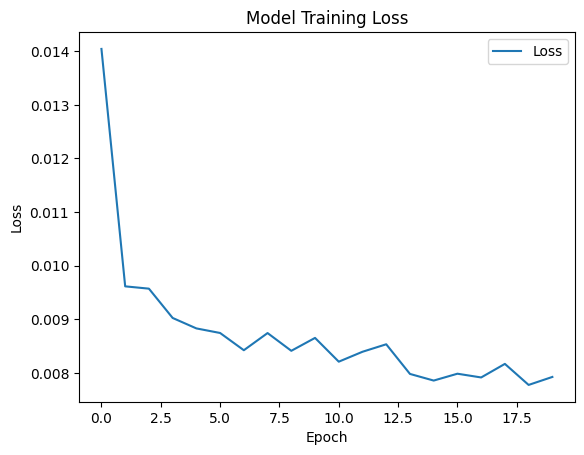

In [88]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training Loss')
plt.legend()
plt.show()

In [89]:
# Evaluate performance on the test set
test_features = df_test.drop(predict_target, axis=1)
test_labels = df_test[[predict_target]]

print("\n Evaluate the new model against the test set:")
model.evaluate(x = test_features, y = test_labels, batch_size=batch_size)


 Evaluate the new model against the test set:
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 0.0082 - mean_squared_error: 0.0082


[0.007831846363842487, 0.007831846363842487]

In [91]:
# Get all test predictions
prediction = model(test_features)
unscaled_predictions = label_scaler.inverse_transform(prediction)

In [105]:
predicted_df = df_test.copy()
predicted_df[[predict_target]] = unscaled_predictions

In [106]:
# See where we predict a price below 0
predicted_df[predicted_df["price"]<0]

,price,sellable_online,other_colors,depth,height,width,discounted,width_d,height_d,depth_d,...,category_Children's furniture,category_Nursery furniture,category_Outdoor furniture,category_Room dividers,"category_Sideboards, buffets & console tables",category_Sofas & armchairs,category_TV & media furniture,category_Tables & desks,category_Trolleys,category_Wardrobes
1869,-216.316431,1,0,0.078125,0.055794,0.050119,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
3405,-364.528536,1,1,0.141212,0.052933,0.140811,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3440,-77.066240,1,0,0.141212,0.141150,0.313331,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
402,-189.115427,1,0,0.195312,0.020029,0.116945,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1064,-193.497150,1,0,0.142553,0.160814,0.233294,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
705,-117.151404,1,0,0.000000,0.004292,0.147971,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
511,-81.429401,1,0,0.140323,0.186119,0.016706,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3396,-41.498299,1,0,0.141212,0.052933,0.140811,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
573,-36.614123,1,0,0.105469,0.186119,0.019093,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3379,-77.066240,1,0,0.141212,0.141150,0.313331,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [101]:
# Save the model and artifacts
Path("artifacts").mkdir(parents=True, exist_ok=True)

model.save("artifacts/model.keras")

with open("artifacts/feature_scaler.pkl", "wb") as handle:
    pickle.dump(feature_scaler, handle)
with open("artifacts/label_scaler.pkl", "wb") as handle:
    pickle.dump(label_scaler, handle)
with open("artifacts/sellable_online_encoder.pkl", "wb") as handle:
    pickle.dump(sellable_online_encoder, handle)
with open("artifacts/other_colors_encoder.pkl", "wb") as handle:
    pickle.dump(other_colors_encoder, handle)

df_train.to_parquet("artifacts/X_train.parquet")
df_test.to_parquet("artifacts/X_test.parquet")